# Bayesian Personalized Ranking (BPR)
> Item recommendation is the task of predicting a personalized ranking on a set of items (e.g. websites, movies, products).
We exploit user browsing data (clicks) as a source implicit feedback. There are many methods for item recommendation from implicit feedback like matrix factorization (MF) or adaptive knearest-neighbor (kNN).
Even though these methods are designed for the item prediction task of personalized ranking, none of them is directly optimized for ranking.
The paper introduces a generic optimization criterion BPR-Opt for personalized ranking that is the maximum posterior estimator derived from a Bayesian analysis of the problem.
The learning method is based on stochastic gradient descent with bootstrap sampling.

TensorFlow implementation of [this research paper](https://arxiv.org/abs/1205.2618).

# 🚀 IMPORTS


In [306]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.sparse as sp
import time

from tqdm import tqdm
from tensorflow.python.client import device_lib

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("notebook")

# 🚀 EXPERIMENT SETTINGS


In [21]:
all_devices = str(device_lib.list_local_devices())
gpu_devices = tf.config.experimental.list_physical_devices("GPU")
if "GPU" in all_devices:
    DEVICE = "GPU"
    MACHINE = "Cloud VM"
elif "CPU" in all_devices:
    DEVICE = "CPU"
    MACHINE = "Local Machine"

print("🧠 Running TensorFlow version {} on {}".format(tf.__version__, DEVICE))

# model constants
epochs = 48
batches = 64
n_latent_vars = 64  # number of latent features for the matrix factorization
n_triplets = 4096  # how many (u,i,j) triplets we sample for each batch

# lambda regularization strength
lambda_id = 0.0
lambda_item = 0.0
lambda_bias = 0.0
learning_rate = 0.005

🧠 Running TensorFlow version 1.15.0 on CPU


# 🚀 PREPARE DATA


In [22]:
t_prep = time.time()  # start timer for preparing data

# load input data
df = pd.read_csv("./data/product_views.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077119 entries, 0 to 2077118
Data columns (total 3 columns):
id               object
visit_date       int64
product_views    object
dtypes: int64(1), object(2)
memory usage: 47.5+ MB


In [23]:
df.head(10)

,id,visit_date,product_views
0,73ce8f218aea5d95b3a29264446da0aa,20191014,"774942,172298"
1,4b9b92eb31de18fbd5a3d6c4e27dabca,20191014,"832354,184434,184388,184434,345944"
2,1561782ee52b1c7e5a5b2a669f39d357,20191014,"818807,818807,818807"
3,8d3478773dfc5bb30754fc2b1258052d,20191014,"822691,795775"
4,e67c7feddd81fbd1a0bada6826cdd14f,20191014,"833416,838406,838391"
5,868dbd237fb2b1dbc0f788c9281cda01,20191014,"787116,682245,787116"
6,ae3b82246138a19ba97b37654ab68f33,20191014,"838334,838338,838337,838337,838337,838338,8383..."
7,ffb145275eeaaf5c65df49966108c397,20191014,"830223,830264"
8,114d1fb650eba8c45b5e6fd5f2a5717d,20191014,"730407,730403,730407,747290,730407"
9,a1a11f2e4c37ad80f53e589d7a5ad0dc,20191014,"774207,774207,781953"


In [24]:
product_map_df = pd.read_csv("./data/product_mapping.csv")  # product id to name key-values
product_map_df["product_id"] = product_map_df["product_id"].astype(str)

# split data into train and test parition
train_partition_final_row = int(0.8 * len(df))
df_test = df[train_partition_final_row:]
df = df[:train_partition_final_row].copy()

df = pd.DataFrame(df["product_views"].str.split(",").tolist(), index=df["id"]).stack()
df = df.reset_index([0, "id"])
df.columns = ["id", "product_id"]
df = df.groupby(df.columns.tolist(), as_index=False).size()
df = df.reset_index(drop=False)
df.columns = ["id", "product_id", "clicks"]
df = df.dropna()
df.head(10)

,id,product_id,clicks
0,000013e374882b95ec0aaf50c8bbfc5f,188643,1
1,000013e374882b95ec0aaf50c8bbfc5f,188710,1
2,000021ac02ec5494a4985bc4ec9bdf1c,831957,1
3,000021ac02ec5494a4985bc4ec9bdf1c,835503,1
4,000021ac02ec5494a4985bc4ec9bdf1c,835512,2
5,000021ac02ec5494a4985bc4ec9bdf1c,837255,1
6,000021ac02ec5494a4985bc4ec9bdf1c,838259,1
7,000021ac02ec5494a4985bc4ec9bdf1c,838354,1
8,00003fdc1bfad78949b697f8958cd54e,675016,1
9,00003fdc1bfad78949b697f8958cd54e,765777,3


In [252]:
df_pt = df.copy()
df_pt['product_type_id'] = df_pt['product_id'].map(dict(zip(product_map_df["product_id"], product_map_df["product_type_id"])))
df_pt['product_type_name'] = df_pt['product_id'].map(dict(zip(product_map_df["product_id"], product_map_df["product_type_name"])))
df_pt['subproduct_type_name'] = df_pt['product_id'].map(dict(zip(product_map_df["product_id"], product_map_df["subproduct_type_name"])))
df_pt['subproduct_type_id'] = df_pt['product_id'].map(dict(zip(product_map_df["product_id"], product_map_df["subproduct_type_id"])))
df_pt['product_name'] = df_pt['product_id'].map(dict(zip(product_map_df["product_id"], product_map_df["product_name"])))
df_pt.dropna(inplace=True)

In [258]:
df_pt['product_type_id'] = df_pt['product_type_id'].astype(np.int)
df_pt['subproduct_type_id'] = df_pt['subproduct_type_id'].astype(np.int)

## SUBPRODUCT_TYPE LEVEL SESSIONS

In [259]:
df_pt.head(10)

,id,product_id,clicks,product_type_id,product_type_name,subproduct_type_name,subproduct_type_id,product_name
0,000013e374882b95ec0aaf50c8bbfc5f,188643,1,17339,bovenfrezen,bovenfrezen,1691,Bosch Groen Bovenfrees POF1200AE
1,000013e374882b95ec0aaf50c8bbfc5f,188710,1,17339,bovenfrezen,bovenfrezen,1691,Ferm Bovenfrees PRM1015
2,000021ac02ec5494a4985bc4ec9bdf1c,831957,1,2093,Mobiele telefoons,Android & Windows Smartphones,2317,Sony Xperia 1 Zwart
3,000021ac02ec5494a4985bc4ec9bdf1c,835503,1,2458,Telefoonhoesjes,Telefoonhoesjes,365,Decoded 2-in-1 Apple iPhone 11 Book Case Leer ...
4,000021ac02ec5494a4985bc4ec9bdf1c,835512,2,2458,Telefoonhoesjes,Telefoonhoesjes,365,Decoded Apple iPhone XIr Back Cover Leer Zwart
5,000021ac02ec5494a4985bc4ec9bdf1c,837255,1,2458,Telefoonhoesjes,Telefoonhoesjes,365,Otterbox Strada iPhone 11 Book Case Zwart
6,000021ac02ec5494a4985bc4ec9bdf1c,838259,1,2458,Telefoonhoesjes,Telefoonhoesjes,365,DBramante1928 Copenhagen Apple iPhone 11 Book ...
7,000021ac02ec5494a4985bc4ec9bdf1c,838354,1,2093,Mobiele telefoons,Android & Windows Smartphones,2317,Sony Xperia 5 Zwart
8,00003fdc1bfad78949b697f8958cd54e,675016,1,6706,Zaagtafels,Zaagtafels,1414,Einhell TH-TS 820 Zaagtafel
9,00003fdc1bfad78949b697f8958cd54e,765777,3,6706,Zaagtafels,Zaagtafels,1414,Einhell TC-TS 1200


In [275]:
df_spt_grouped = df_pt[['id', 'clicks', 'subproduct_type_id']].groupby(['id']).agg({'clicks': 'sum', 'subproduct_type_id': 'nunique'})
df_spt_grouped.reset_index(drop=False, inplace=True)
df_spt_grouped.head(10)

,id,clicks,subproduct_type_id
0,000013e374882b95ec0aaf50c8bbfc5f,2,1
1,000021ac02ec5494a4985bc4ec9bdf1c,7,2
2,00003fdc1bfad78949b697f8958cd54e,8,1
3,000055dc8a1f1fd7094ec242e0e73f73,2,1
4,00006fc5a8c12e76bb385a84783d3200,2,1
5,00007578c776bad1d6e38e12ba41d1fe,5,1
6,0000c4c5997f7bb5f832ca4195ab07c1,2,1
7,0000ca50e30aecb0b8814c9ba13affc5,3,1
8,0000dd2e19ca1923fc531afc6a7d3d82,2,1
9,0000e1096666c03d8c1d075a824c6678,5,2


In [312]:
df_clicks_grouped_counts = pd.DataFrame(df_spt_grouped['clicks'].value_counts()).reset_index(drop=False)
df_clicks_grouped_counts.columns = ['clicks', 'count']

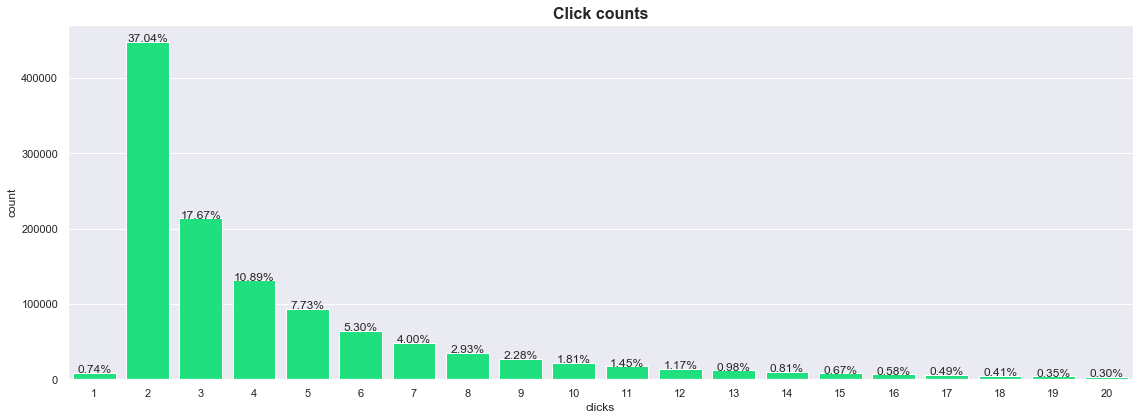

In [330]:
plt.figure(figsize=(16,6))
ax = sns.barplot(data=df_clicks_grouped_counts[0:20], x='clicks', y='count', color="springgreen", label="Click counts")
plt.title('Click counts', weight='bold').set_fontsize('16')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(df_spt_grouped)*100),
            ha="center").set_fontsize('12')
plt.tight_layout()
plt.savefig("plots/click_counts.png")

In [279]:
df_spt_grouped_counts = pd.DataFrame(df_spt_grouped['subproduct_type_id'].value_counts()).reset_index(drop=False)
df_spt_grouped_counts.columns = ['unique_subproduct_type_ids', 'count']

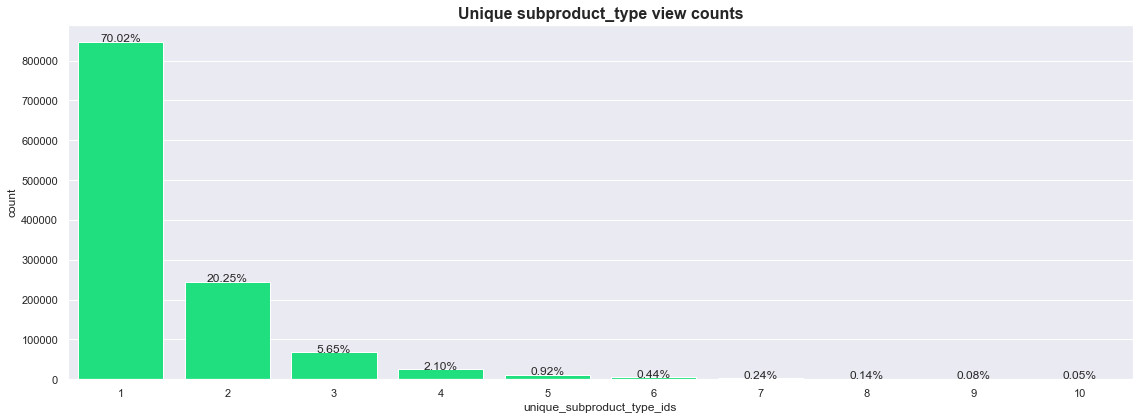

In [329]:
plt.figure(figsize=(16,6))
ax = sns.barplot(data=df_spt_grouped_counts[0:10], x='unique_subproduct_type_ids', y='count', color="springgreen", label="subproduct_type view counts")
plt.title('Unique subproduct_type view counts', weight='bold').set_fontsize('16')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(df_spt_grouped)*100),
            ha="center").set_fontsize('12')
plt.tight_layout()
plt.savefig("plots/subproduct_type_counts.png")

## PRODUCT LEVEL SESSIONS

In [96]:
df_id_counts = pd.DataFrame(df_pt['id'].value_counts()).reset_index(drop=False)
df_id_counts.columns = ['id', 'unique_prod_views']
df_id_counts[0:25]

,id,unique_prod_views
50,933e51d98396706aefc6e853ff7423e9,71
51,d7b1c9201e61eb4f7f441ee9042676ff,70
52,14223a2bd5e30bde743b78bc99634c3a,70
53,f0a978c3be176bb12f99b04363df11a7,69
54,452540e098be56e32dbba4bd4e7212ca,68
55,ffcbfbb7c73887df425e0896cb72a697,68
56,a8f65786a60bfa0f070bf50d3ccb88c4,68
57,20168eff3c5391c7850a1a660b377264,68
58,8190858afa7f4161c08fc129c3254879,68
59,43666b1e9a04c1d75381c12ef8271889,68


In [101]:
df_view_counts = pd.DataFrame(df_id_counts['unique_prod_views'].value_counts()).reset_index(drop=False)
df_view_counts.columns = ['unique_prod_views', 'count']
df_view_counts[0:25]

,unique_prod_views,count
0,2,424765
1,1,269537
2,3,187187
3,4,109740
4,5,67251
5,6,43203
6,7,29094
7,8,20254
8,9,14582
9,10,10722


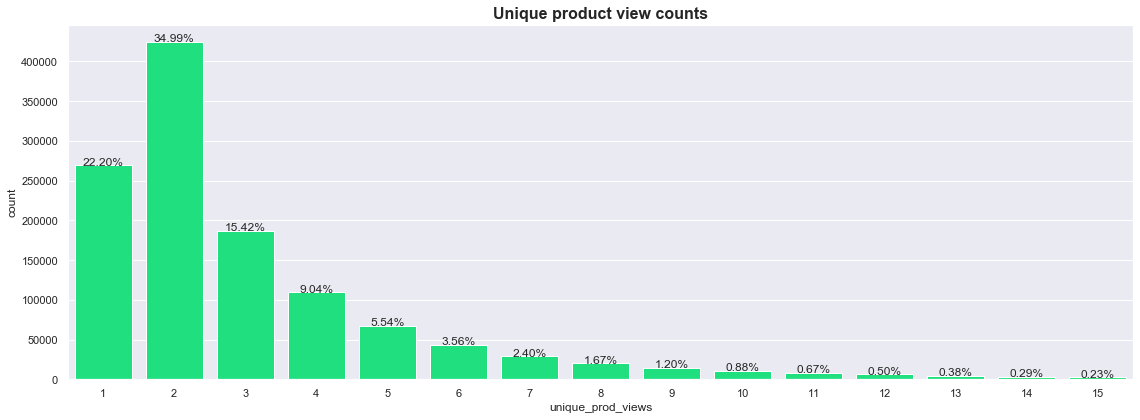

In [331]:
plt.figure(figsize=(16,6))
ax = sns.barplot(data=df_view_counts[0:15], x='unique_prod_views', y='count', color="springgreen", label="view counts")
plt.title('Unique product view counts', weight='bold').set_fontsize('16')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/np.sum(df_view_counts['count'])*100),
            ha="center").set_fontsize('12')
plt.tight_layout()
plt.savefig("plots/product_type_counts.png")

In [196]:
df_pt.iloc[2:8]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
2,000021ac02ec5494a4985bc4ec9bdf1c,831957,1,Mobiele telefoons,Android & Windows Smartphones,Sony Xperia 1 Zwart
3,000021ac02ec5494a4985bc4ec9bdf1c,835503,1,Telefoonhoesjes,Telefoonhoesjes,Decoded 2-in-1 Apple iPhone 11 Book Case Leer ...
4,000021ac02ec5494a4985bc4ec9bdf1c,835512,2,Telefoonhoesjes,Telefoonhoesjes,Decoded Apple iPhone XIr Back Cover Leer Zwart
5,000021ac02ec5494a4985bc4ec9bdf1c,837255,1,Telefoonhoesjes,Telefoonhoesjes,Otterbox Strada iPhone 11 Book Case Zwart
6,000021ac02ec5494a4985bc4ec9bdf1c,838259,1,Telefoonhoesjes,Telefoonhoesjes,DBramante1928 Copenhagen Apple iPhone 11 Book ...
7,000021ac02ec5494a4985bc4ec9bdf1c,838354,1,Mobiele telefoons,Android & Windows Smartphones,Sony Xperia 5 Zwart


In [197]:
df_pt.iloc[45:52]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
45,00014881553db0602627f90078d2b015,214687,1,Magnetrons,Vrijstaande solo magnetrons,Bosch HMT72M420
46,00014881553db0602627f90078d2b015,674170,4,Strijkijzers,Stoomgeneratoren,Tefal Express Easy Plus GV7556
47,00014881553db0602627f90078d2b015,674172,6,Strijkijzers,Stoomgeneratoren,Tefal GV8931 Pro Express
48,00014881553db0602627f90078d2b015,800046,1,Magnetrons,Inbouw combimagnetrons,Bosch CMA583MS0
49,00014881553db0602627f90078d2b015,828546,7,Strijkijzers,Stoomgeneratoren,Tefal Express Anti-Calc SV8055
50,00014881553db0602627f90078d2b015,829714,2,Strijkijzers,Stoomgeneratoren,Philips PerfectCare Elite GC9650/80
51,00014881553db0602627f90078d2b015,837782,2,Strijkijzers,Stoomgeneratoren,Philips PerfectCare Compact Plus


In [198]:
df_pt.iloc[188:192]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
188,0003f612b9e6c3e78757acbf106b3e94,713096,3,Consoles,Sony Playstation consoles,Sony PlayStation 4 Pro 1 TB
189,0003f612b9e6c3e78757acbf106b3e94,797141,1,Controllers,Controllers,Nacon PS4 Official Wired Controller Zwart
190,0003f612b9e6c3e78757acbf106b3e94,821379,1,Controllers,Controllers,Razer Raiju Tournament Ed Gaming Wireless Cont...
191,0003f612b9e6c3e78757acbf106b3e94,839184,4,Consoles,NaN,Sony PlayStation 4 Pro 1 TB + 2 Dualshock Cont...


In [199]:
df_pt.iloc[263:272]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
263,0005551011655ffa68b269dcb166ce11,662086,1,Monitoren,Computermonitoren,AOC Q2778VQE
264,0005551011655ffa68b269dcb166ce11,775232,1,Monitoren,Computermonitoren,iiyama ProLite XUB2792QSU-B1
265,0005551011655ffa68b269dcb166ce11,787944,1,Monitoren,Gaming monitoren,iiyama G-Master Red Eagle GB2760QSU-B1
266,0005551011655ffa68b269dcb166ce11,795842,4,Monitoren,Computermonitoren,AOC Q2790PQU
267,0005551011655ffa68b269dcb166ce11,805011,1,Monitoren,Gaming monitoren,iiyama G-Master GB2730QSU-B1
268,0005551011655ffa68b269dcb166ce11,809983,1,Monitoren,Computermonitoren,Lenovo L27q-10
269,0005551011655ffa68b269dcb166ce11,814248,1,Monitoren,Computermonitoren,AOC 24B1H
270,0005551011655ffa68b269dcb166ce11,833781,1,Monitoren,Computermonitoren,LG 27UL500
271,0005551011655ffa68b269dcb166ce11,835210,2,Monitoren,Computermonitoren,AOC U2790PQU


In [200]:
df_pt[10021:10049]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
10021,00a6a7955cf9868a80f3732f59664d2b,719690,2,slimme horloges,Slimme horloges,Garmin Forerunner 735XT Zwart
10022,00a6a7955cf9868a80f3732f59664d2b,760611,1,slimme horloges,Slimme horloges,Garmin Fenix 5 Zwart
10023,00a6a7955cf9868a80f3732f59664d2b,784744,3,slimme horloges,Slimme horloges,Garmin Forerunner 935
10024,00a6afb78eb2b3a5bdf61596c7a33cbb,12624,2,Aux kabels,Aux kabels,Valueline 3.5 mm Stereo Kabel 5 meter
10025,00a6afb78eb2b3a5bdf61596c7a33cbb,653318,1,Aux kabels,Aux kabels,"Konig 3,5 mm Verlengkabel 3 meter Zwart"
10026,00a6afb78eb2b3a5bdf61596c7a33cbb,715148,1,Powerbanks,Non-solar powerbanks,PowerOak K2 Powerbank 50.000 mAh
10027,00a6afb78eb2b3a5bdf61596c7a33cbb,732716,1,microfoonstandaarden,microfoonstandaarden,Rode PSA1
10028,00a6afb78eb2b3a5bdf61596c7a33cbb,757469,1,Microfoons,Microfoons,Audio Technica AT2035
10029,00a6afb78eb2b3a5bdf61596c7a33cbb,786626,3,Racesturen,NaN,Logitech G29 Driving Force + Logitech Driving ...
10030,00a6afb78eb2b3a5bdf61596c7a33cbb,788941,1,Hoofdtelefoons,Hoofdtelefoons met noisecancelling,Bose QuietComfort 35 II Zwart


In [201]:
df_pt[28088:28095]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
28088,01c924d2010487bae8c656dbdfd79548,481317,1,Koffers,Grote koffers,Samsonite S'Cure Spinner 75 cm Aqua Blue
28089,01c924d2010487bae8c656dbdfd79548,481331,2,Koffers,Handbagage koffers,Samsonite S'Cure Spinner 55 cm Black
28090,01c924d2010487bae8c656dbdfd79548,481332,1,Koffers,Handbagage koffers,Samsonite S'Cure Spinner 55 cm Crimson Red
28091,01c924d2010487bae8c656dbdfd79548,481333,3,Koffers,Handbagage koffers,Samsonite S'Cure Spinner 55 cm Dark Blue
28092,01c924d2010487bae8c656dbdfd79548,711057,1,Koffers,Grote koffers,Samsonite S'Cure Spinner 75 cm Silver
28093,01c924d2010487bae8c656dbdfd79548,744588,1,Koffers,Grote koffers,Samsonite S'Cure Spinner 81 cm Black
28094,01c924d2010487bae8c656dbdfd79548,744589,1,Koffers,Grote koffers,Samsonite S'Cure Spinner 81 cm Crimson Red


In [202]:
df_pt[30067:30080]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
30067,01e707c32fb500886b6dd390fca8d281,222838,1,Kabel converters,Kabel converters,Apple Lightning to MicroUSB Adapter
30068,01e707c32fb500886b6dd390fca8d281,233170,3,Kabel converters,Kabel converters,Apple Lightning to USB Camera Adapter
30069,01e707c32fb500886b6dd390fca8d281,749227,3,Harde schijven intern HDD,Harde schijven intern HDD,Seagate BarraCuda ST1000LM048 1 TB
30070,01e707c32fb500886b6dd390fca8d281,750006,2,Harde schijven intern HDD,Harde schijven intern HDD,Seagate Ironwolf ST4000VN008 4 TB
30071,01e707c32fb500886b6dd390fca8d281,819018,3,Telefoonhoesjes,Telefoonhoesjes,Decoded Leather Slim Wallet iPhone Xr Book Cas...
30072,01e707c32fb500886b6dd390fca8d281,819019,1,Telefoonhoesjes,Telefoonhoesjes,Decoded Leather Slim Wallet iPhone Xr Book Cas...
30073,01e707c32fb500886b6dd390fca8d281,819020,2,Telefoonhoesjes,Telefoonhoesjes,Decoded Leather Slim Wallet iPhone Xr Book Cas...
30074,01e707c32fb500886b6dd390fca8d281,819025,1,Telefoonhoesjes,Telefoonhoesjes,Decoded 2-in-1 Leather Wallet iPhone Xr Book C...
30075,01e707c32fb500886b6dd390fca8d281,819348,5,Mobiele telefoons,iPhones,Apple iPhone Xr 256 GB Zwart
30076,01e707c32fb500886b6dd390fca8d281,819447,1,Telefoonhoesjes,Telefoonhoesjes,DBramante1928 Copenhagen iPhone Xr Book Case Z...


In [203]:
df_pt[df_pt['id'] == 'fda98fd9b3be7d6950270c49473db2f9'][0:50]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
3875710,fda98fd9b3be7d6950270c49473db2f9,110148,1,toners,Toner cartridge kleur,Brother TN-320M (Magenta)
3875711,fda98fd9b3be7d6950270c49473db2f9,202736,1,toners,Toner cartridge kleur,HP 507A Laserjet Toner Geel
3875712,fda98fd9b3be7d6950270c49473db2f9,316262,1,office headsets,Headsets Office,Sennheiser DW Pro 1 Wireless Professional head...
3875713,fda98fd9b3be7d6950270c49473db2f9,320849,1,remote triggers,remote triggers,Falcon Eyes Radio Trigger Set RF-A2416
3875714,fda98fd9b3be7d6950270c49473db2f9,325849,1,toners,Toner cartridge kleur,Brother TN-245M
3875715,fda98fd9b3be7d6950270c49473db2f9,345872,1,toners,Toner cartridge kleur,HP 504A LaserJet Toner Cyaan (CE251A)
3875716,fda98fd9b3be7d6950270c49473db2f9,352045,1,Audiostreamers,Audiostreamers receivers,Autovision AV-BT Link
3875717,fda98fd9b3be7d6950270c49473db2f9,372059,1,stofzuigerborstels,Stofzuigeropzetstukken,Dyson Home Cleaning Kit
3875718,fda98fd9b3be7d6950270c49473db2f9,399484,1,Geurolien,Geurolien,Medisana Geurolie Lavendel
3875719,fda98fd9b3be7d6950270c49473db2f9,399685,1,Luchtbevochtigers,Luchtbevochtigers,Stadler Form Oskar Big White


In [204]:
df_pt[df_pt['id'] == '7fec50a89e746742a1ac908b8f244616'][0:50]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
1953099,7fec50a89e746742a1ac908b8f244616,132897,1,Koffers,Handbagage koffers,"Targus Executive Trolley 15,6"" Zwart"
1953100,7fec50a89e746742a1ac908b8f244616,470190,1,Autostoelspiegels,Autostoelspiegels,Safety 1st Achteruitkijkspiegel
1953101,7fec50a89e746742a1ac908b8f244616,505073,1,Robotstofzuigers,Robotstofzuigers,Dyson 360 Eye
1953102,7fec50a89e746742a1ac908b8f244616,563821,2,Muizen,Muizen,Trust Yvi Draadloze Muis Zwart
1953103,7fec50a89e746742a1ac908b8f244616,563823,3,Muizen,Muizen,Trust Yvi Draadloze Muis Flower
1953104,7fec50a89e746742a1ac908b8f244616,715801,1,Koffers,Handbagage koffers,Leitz Complete Smart Carry-On Trolley Zwart
1953105,7fec50a89e746742a1ac908b8f244616,728972,13,Koffers,Handbagage koffers,"Samsonite XBR Rolling Tote 15,6"""
1953106,7fec50a89e746742a1ac908b8f244616,736126,1,Muizen,Muizen,Logitech M220 Silent Draadloze Muis Zwart
1953107,7fec50a89e746742a1ac908b8f244616,736170,1,Muizen,Muizen,Logitech M330 Silent Draadloze Muis Zwart
1953108,7fec50a89e746742a1ac908b8f244616,742299,1,Dweilrobots,Dweilrobots,iRobot Braava Jet 240


In [205]:
df_pt[df_pt['id'] == '9ec47eb4a5432bc32a998224e79585f0'][0:50]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
2422875,9ec47eb4a5432bc32a998224e79585f0,793451,1,Harde schijven extern,Harde schijven extern,WD My Book Duo 6TB
2422876,9ec47eb4a5432bc32a998224e79585f0,800637,1,desktops,iMac's,"Apple iMac 21,5"" (2017) MMQA2N/A 2,3GHz 8GB/256GB"
2422877,9ec47eb4a5432bc32a998224e79585f0,804955,1,Intern geheugen,SO-Dimm modules,Crucial Apple 32 GB SODIMM DDR4-2400 Kit 2 x 16
2422878,9ec47eb4a5432bc32a998224e79585f0,820797,2,Harde schijven extern,Harde schijven extern,LaCie d2 Professional USB 3.1-C 4TB
2422879,9ec47eb4a5432bc32a998224e79585f0,822567,9,desktops,Mac mini's,"Apple Mac Mini (2018) 3,6Ghz 8GB/128GB"
2422880,9ec47eb4a5432bc32a998224e79585f0,822568,13,desktops,Mac mini's,"Apple Mac Mini (2018) 3,0GHz 8GB/256GB"
2422881,9ec47eb4a5432bc32a998224e79585f0,822569,3,desktops,Mac mini's,"Apple Mac Mini (2018) 3,6GHz i3 8GB/128GB - 10..."
2422882,9ec47eb4a5432bc32a998224e79585f0,822570,3,desktops,Mac mini's,"Apple Mac Mini (2018) 3,6GHz i3 8GB/256GB - 10..."
2422883,9ec47eb4a5432bc32a998224e79585f0,822572,2,desktops,Mac mini's,"Apple Mac Mini (2018) 3,6GHz i3 16GB/128GB - 1..."
2422884,9ec47eb4a5432bc32a998224e79585f0,822573,3,desktops,Mac mini's,"Apple Mac Mini (2018) 3,6GHz i3 16GB/256GB - 1..."


In [215]:
df_pt[df_pt['id'] == '43077e0c3733569eacddb31515a26e2f'][0:50]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
1026138,43077e0c3733569eacddb31515a26e2f,105273,1,Ontkalker voor koffiezetapparaten,Ontkalker voor koffiezetapparaten,Krups Ontkalkingsset F054
1026139,43077e0c3733569eacddb31515a26e2f,128602,1,pc speakers,pc speakers,Logitech Z906 5.1 Surround Sound Speakers
1026140,43077e0c3733569eacddb31515a26e2f,340932,2,Opladers voor consoles en controllers,Opladers voor consoles en controllers,Microsoft Xbox One Play & Charge Kit
1026141,43077e0c3733569eacddb31515a26e2f,518335,1,Koffieapparaten Cups & Pads,Dolce Gusto koffieapparaten,Krups Dolce Gusto Genio 2 Rood KP1605 (BE)
1026142,43077e0c3733569eacddb31515a26e2f,563689,1,pc speakers,pc speakers,Edifier Studio R1700BT 2.0 (per paar)
1026143,43077e0c3733569eacddb31515a26e2f,595944,2,pc speakers,pc speakers,Bose Companion 50
1026144,43077e0c3733569eacddb31515a26e2f,762918,1,toetsenborden,Gaming toetsenborden QWERTY,Corsair K95 RGB Platinum Cherry MX Speed (Qwerty)
1026145,43077e0c3733569eacddb31515a26e2f,766653,2,toetsenborden,Gaming toetsenborden AZERTY,Corsair K95 RGB Platinum Cherry MX Brown (Azerty)
1026146,43077e0c3733569eacddb31515a26e2f,766657,5,toetsenborden,Gaming toetsenborden AZERTY,Corsair K95 RGB Platinum Cherry MX Speed (Azerty)
1026147,43077e0c3733569eacddb31515a26e2f,774092,2,toetsenborden,Gaming toetsenborden AZERTY,Corsair K63 Cherry MX Red (Azerty)


In [223]:
df_pt[df_pt['id'] == '76eb9902768b5ebc9b914b0c7731e4d2'][0:50]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
1816318,76eb9902768b5ebc9b914b0c7731e4d2,688625,1,Koelkasten,Vrijstaande koel-vriescombinaties,Bosch KGE58BI40
1816319,76eb9902768b5ebc9b914b0c7731e4d2,712225,1,Koelkasten,Vrijstaande koel-vriescombinaties,Siemens KG39NXI46
1816320,76eb9902768b5ebc9b914b0c7731e4d2,718864,1,Koelkasten,Vrijstaande koel-vriescombinaties,Siemens KG56NXI30
1816321,76eb9902768b5ebc9b914b0c7731e4d2,745971,1,Koelkasten,Amerikaanse koelkasten,Samsung RF62HEPN1/XEF
1816322,76eb9902768b5ebc9b914b0c7731e4d2,776905,1,Koelkasten,Amerikaanse koelkasten,AEG RMB86321NX
1816323,76eb9902768b5ebc9b914b0c7731e4d2,779359,1,Koelkasten,Amerikaanse koelkasten,Samsung RFG23RESL1/XEF
1816324,76eb9902768b5ebc9b914b0c7731e4d2,811301,1,Koelkasten,Vrijstaande koel-vriescombinaties,Haier A3FE835CGJE Easy Access
1816325,76eb9902768b5ebc9b914b0c7731e4d2,814593,1,Koelkasten,Vrijstaande koel-vriescombinaties,Bosch KGE366L4Q
1816326,76eb9902768b5ebc9b914b0c7731e4d2,814602,1,Koelkasten,Vrijstaande koel-vriescombinaties,Bosch KGN36IJ3A Vario Style
1816327,76eb9902768b5ebc9b914b0c7731e4d2,820764,1,Koelkasten,Vrijstaande koel-vriescombinaties,Bosch KGE49VI4A


In [225]:
df_pt[df_pt['id'] == 'b6455a236063201e8a4f3ce40d763c2e'][0:50]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
2781604,b6455a236063201e8a4f3ce40d763c2e,142254,2,Ijsbereiders voor keukenmixers,Ijsbereiders voor keukenmixers,KitchenAid 5KICA0WH Roomijsmaker
2781605,b6455a236063201e8a4f3ce40d763c2e,142402,2,Raspen voor keukenmixers,Raspen voor keukenmixers,KitchenAid FPPC Hulpstukkenpakket
2781606,b6455a236063201e8a4f3ce40d763c2e,400664,2,Ovens,Inbouw solo ovens,Miele DG 6100
2781607,b6455a236063201e8a4f3ce40d763c2e,525506,1,Schenkschilden voor keukenmixers,Schenkschilden voor keukenmixers,KitchenAid 5KN1PS Schenkschild
2781608,b6455a236063201e8a4f3ce40d763c2e,734987,8,Keukenmixers,Keukenmixers,KitchenAid Artisan Mixer 5KSM175PS Vulkaanzwart
2781609,b6455a236063201e8a4f3ce40d763c2e,734991,2,Keukenmixers,Keukenmixers,KitchenAid Artisan Mixer 5KSM175PS Appelrood
2781610,b6455a236063201e8a4f3ce40d763c2e,734995,1,Keukenmixers,Keukenmixers,KitchenAid Artisan Mixer 5KSM175PS Frambozenijs
2781611,b6455a236063201e8a4f3ce40d763c2e,735006,2,Keukenmixers,Keukenmixers,KitchenAid Artisan Mixer 5KSM175PS Espresso
2781612,b6455a236063201e8a4f3ce40d763c2e,735009,1,Keukenmixers,Keukenmixers,KitchenAid Artisan Mixer 5KSM175PS Tingrijs
2781613,b6455a236063201e8a4f3ce40d763c2e,735200,1,Pasta opzetstukken voor keukenmixers,Pasta opzetstukken voor keukenmixers,KitchenAid 5KSMPRA Pasta Roller en Snijder Set...


In [238]:
df_pt[df_pt['id'] == 'fd5378908027694c1fbae12ab932a1d9'][0:50]

,id,product_id,clicks,product_type_name,subproduct_type_name,product_name
3870334,fd5378908027694c1fbae12ab932a1d9,434494,1,Digitale camera's compact,Digitale camera's compact,Sony CyberShot DSC-W810 Black
3870335,fd5378908027694c1fbae12ab932a1d9,552559,2,Digitale camera's compact,Digitale camera's compact,Panasonic Lumix DMC-TZ70 zwart
3870336,fd5378908027694c1fbae12ab932a1d9,554716,2,Digitale camera's compact,Digitale camera's compact,Panasonic Lumix DMC-TZ57 zwart
3870337,fd5378908027694c1fbae12ab932a1d9,557332,1,Digitale camera's compact,Digitale camera's compact,Panasonic Lumix DMC-SZ10 zwart
3870338,fd5378908027694c1fbae12ab932a1d9,622985,2,Digitale camera's compact,Digitale camera's compact,Sony CyberShot DSC-WX500 zwart
3870339,fd5378908027694c1fbae12ab932a1d9,690101,1,Digitale camera's compact,Digitale camera's compact,Canon PowerShot SX420 IS Zwart
3870340,fd5378908027694c1fbae12ab932a1d9,716864,1,Digitale camera's compact,Digitale camera's compact,Nikon Coolpix B500
3870341,fd5378908027694c1fbae12ab932a1d9,761131,1,Digitale camera's compact,Digitale camera's compact,Canon PowerShot SX430
3870342,fd5378908027694c1fbae12ab932a1d9,770061,1,Digitale camera's compact,Digitale camera's compact,Panasonic Lumix DC-FZ82
3870343,fd5378908027694c1fbae12ab932a1d9,805235,1,Digitale camera's compact,Digitale camera's compact,Fujifilm FinePix XP130 Sky Blue


In [232]:
df_id_counts[25000:25050]

,id,unique_prod_views
25000,9a13f2cf19ed6aaaf0db653d8ad26868,12
25001,c3e30e3d8ace722ba879d56a9c17a3d2,12
25002,d113c9746e7a887f01582f649255479a,12
25003,8b9f136f09b4a5b6bbdbbb9af28d3d3f,12
25004,39df88e07955b67367b6968028cf6ca1,12
25005,0960c1f737aef60640152f9647032e41,12
25006,f40e15d87f63e479cd52327f3faf629d,12
25007,373301d86387d780ac3380e49aa26628,12
25008,0b50dd83519ccea04bb898dde5928794,12
25009,e316c29e12133cfecd415f61b2f3bd6e,12


In [5]:
# Convert product_ids names into integer ids
df["cookie_token"] = df["id"].astype("category").cat.codes
df["product_token"] = df["product_id"].astype("category").cat.codes

# Create a lookup frame so we can get the product_ids back later
item_lookup = df[["product_token", "product_id"]].drop_duplicates()
item_lookup["product_token"] = item_lookup.product_token.astype(str)
df = df.drop(["id", "product_id"], axis=1)
df = df.loc[df.clicks != 0]  # drop sessions without views (contain no information)
df.head(3)

# lists of all ids, product_ids and clicks
ids = list(np.sort(df.cookie_token.unique()))
product_ids = list(np.sort(df.product_token.unique()))
clicks = list(df.clicks)

# rows and columns for our new matrix
rows = df.cookie_token.astype(float)
cols = df.product_token.astype(float)

# contruct a sparse matrix for our ids and items containing number of clicks
data_sparse = sp.csr_matrix((clicks, (rows, cols)), shape=(len(ids), len(product_ids)))
uids, iids = data_sparse.nonzero()

print("⏱️ Elapsed time for processing input data: {:.3} seconds".format(time.time() - t_prep))

⏱️ Elapsed time for processing input data: 49.3 seconds


# 🚀 DEFINE TENSORFLOW GRAPH


In [31]:
graph = tf.Graph()


def init_variable(size, dim, name=None):
    """
    Helper function to initialize a new variable with
    uniform random values.
    """
    std = np.sqrt(2 / dim)
    return tf.Variable(tf.random_uniform([size, dim], -std, std), name=name)


def embed(inputs, size, dim, name=None):
    """
    Helper function to get a Tensorflow variable and create
    an embedding lookup to map our id and item
    indices to vectors.
    """
    emb = init_variable(size, dim, name)
    return tf.nn.embedding_lookup(emb, inputs)


def get_variable(graph, session, name):
    """
    Helper function to get the value of a
    Tensorflow variable by name.
    """
    v = graph.get_operation_by_name(name)
    v = v.values()[0]
    v = v.eval(session=session)
    return v


with graph.as_default():
    """
    Loss function:
    -SUM ln σ(xui - xuj) + λ(w1)**2 + λ(w2)**2 + λ(w3)**2 ...
    ln = the natural log
    σ(xuij) = the sigmoid function of xuij.
    λ = lambda regularization value.
    ||W||**2 = the squared L2 norm of our model parameters.

    """

    # Input into our model,  id (u), known item (i) an unknown item (i) triplets
    u = tf.placeholder(tf.int32, shape=(None, 1))
    i = tf.placeholder(tf.int32, shape=(None, 1))
    j = tf.placeholder(tf.int32, shape=(None, 1))

    # id feature embedding
    u_factors = embed(u, len(ids), n_latent_vars, "id_factors")  # U matrix

    # Known and unknown item embeddings
    item_factors = init_variable(len(product_ids), n_latent_vars, "item_factors")  # V matrix
    i_factors = tf.nn.embedding_lookup(item_factors, i)
    j_factors = tf.nn.embedding_lookup(item_factors, j)

    # i and j bias embeddings
    item_bias = init_variable(len(product_ids), 1, "item_bias")
    i_bias = tf.nn.embedding_lookup(item_bias, i)
    i_bias = tf.reshape(i_bias, [-1, 1])
    j_bias = tf.nn.embedding_lookup(item_bias, j)
    j_bias = tf.reshape(j_bias, [-1, 1])

    # Calculate the dot product + bias for known and unknown item to get xui and xuj
    xui = i_bias + tf.reduce_sum(u_factors * i_factors, axis=2)
    xuj = j_bias + tf.reduce_sum(u_factors * j_factors, axis=2)
    xuij = xui - xuj

    # Calculate the mean AUC (area under curve). If xuij is greater than 0, that means that xui is
    # greater than xuj (and thats what we want).
    u_auc = tf.reduce_mean(tf.cast(xuij > 0, float))
    tf.summary.scalar("auc", u_auc)

    # Calculate the squared L2 norm ||W||**2 multiplied by λ
    l2_norm = tf.add_n(
        [
            lambda_id * tf.reduce_sum(tf.multiply(u_factors, u_factors)),
            lambda_item * tf.reduce_sum(tf.multiply(i_factors, i_factors)),
            lambda_item * tf.reduce_sum(tf.multiply(j_factors, j_factors)),
            lambda_bias * tf.reduce_sum(tf.multiply(i_bias, i_bias)),
            lambda_bias * tf.reduce_sum(tf.multiply(j_bias, j_bias)),
        ]
    )

    # Calculate the loss as ||W||**2 - ln σ(Xuij)
    # loss = l2_norm - tf.reduce_mean(tf.log(tf.sigmoid(xuij)))
    loss = -tf.reduce_mean(tf.log(tf.sigmoid(xuij))) + l2_norm

    # Train using the Adam optimizer to minimize our loss function
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
    step = opt.minimize(loss)
    init = tf.global_variables_initializer()

# 🚀 MODEL TRAINING


In [32]:
t_train = time.time()  # start timer for training

session = tf.Session(config=None, graph=graph)
session.run(init)

progress = tqdm(total=batches * epochs)  # progress bar for the training.

for _ in range(epochs):
    for _ in range(batches):

        # We want to sample one known and one unknown
        # item for each id.

        # First we sample 15000 uniform indices.
        idx = np.random.randint(low=0, high=len(uids), size=n_triplets)

        # We then grab the ids matching those indices
        batch_u = uids[idx].reshape(-1, 1)

        # Then the known items for those ids
        batch_i = iids[idx].reshape(-1, 1)

        # Lastly we randomly sample one unknown item for each id
        batch_j = np.random.randint(
            low=0, high=len(product_ids), size=(n_triplets, 1), dtype="int32"
        )

        # Feed our ids, known and unknown items to
        # our tensorflow graph.
        feed_dict = {u: batch_u, i: batch_i, j: batch_j}

        # We run the session.
        _, l, auc = session.run([step, loss, u_auc], feed_dict)

    progress.update(batches)
    progress.set_description("Loss: %.3f | AUC: %.3f" % (l, auc))

progress.close()

train_time = time.time() - t_tbrain
print(
    "⏱️ Elapsed time for training on {} sequences: {:.3} minutes".format(len(df), train_time / 60)
)

Loss: 0.613 | AUC: 0.661:   6%|▋         | 192/3072 [01:39<24:45,  1.94it/s]

KeyboardInterrupt: 

# 🚀 DEFINE SIMILARITY LOOK UP AND RECOMMENDATIONS



In [ ]:
def find_similar_product_ids(product_id=None, num_items=15):
    """Find product_ids similar to an product_id.
    Args:
        product_id (str): The name of the product_id we want to find similar product_ids for
        num_items (int): How many similar product_ids we want to return.
    Returns:
        similar (pandas.DataFrame): DataFrame with num_items product_id names and scores
    """

    id_vecs = get_variable(graph, session, "id_factors")  # matrix U
    item_vecs = get_variable(graph, session, "item_factors")  # matrix V
    item_bias = get_variable(graph, session, "item_bias").reshape(-1)
    item_id = int(item_lookup[item_lookup.product_id == product_id]["product_token"])
    item_vec = item_vecs[item_id].T  # Transpose item vector

    # Calculate the similarity between this product and all other product_ids
    # by multiplying the item vector with our item_matrix
    scores = np.add(item_vecs.dot(item_vec), item_bias).reshape(1, -1)[0]
    top_10 = np.argsort(scores)[::-1][:num_items]  # Indices of top similarities

    # Map the indices to product_id names
    product_ids, product_id_scores = [], []

    for idx in top_10:
        product_ids.append(
            item_lookup.product_id.loc[item_lookup.product_token == str(idx)].iloc[0]
        )
        product_id_scores.append(scores[idx])

    similar = pd.DataFrame({"product_id": product_ids, "score": product_id_scores})
    similar["product_name"] = similar["product_id"].map(
        dict(zip(product_map_df["product_id"], product_map_df["product_name"]))
    )
    similar["product_type_name"] = similar["product_id"].map(
        dict(zip(product_map_df["product_id"], product_map_df["product_type_name"]))
    )

    return similar

In [ ]:
def make_recommendation(cookie_token=None, num_items=5):
    """Recommend items for a given id given a trained model
    Args:
        cookie_token (int): The id of the id we want to create recommendations for.
        num_items (int): How many recommendations we want to return.
    Returns:
        recommendations (pandas.DataFrame): DataFrame with num_items product_id names and scores
    """

    # make df of the session for input token
    clicks = df[df["cookie_token"] == cookie_token].merge(
        item_lookup, on="product_token", how="left"
    )
    clicks["product_name"] = clicks["product_id"].map(
        dict(zip(product_map_df["product_id"], product_map_df["product_name"]))
    )
    clicks["product_type_name"] = clicks["product_id"].map(
        dict(zip(product_map_df["product_id"], product_map_df["product_type_name"]))
    )

    print("Making implicit feedback recommendations for observed user views: \n{}".format(clicks))
    print("\n----------------------⟶\n")

    id_vecs = get_variable(graph, session, "id_factors")  # matrix U
    item_vecs = get_variable(graph, session, "item_factors")  # matrix V
    item_bias = get_variable(graph, session, "item_bias").reshape(-1)
    rec_vector = np.add(id_vecs[cookie_token, :].dot(item_vecs.T), item_bias)
    item_idx = np.argsort(rec_vector)[::-1][:num_items]  # get indices of top cooki

    # Map the indices to product_id names
    product_ids, scores = [], []

    for idx in item_idx:
        product_ids.append(
            item_lookup.product_id.loc[item_lookup.product_token == str(idx)].iloc[0]
        )
        scores.append(rec_vector[idx])

    recommendations = pd.DataFrame({"product_id": product_ids, "score": scores})
    recommendations["product_name"] = recommendations["product_id"].map(
        dict(zip(product_map_df["product_id"], product_map_df["product_name"]))
    )
    recommendations["product_type_name"] = recommendations["product_id"].map(
        dict(zip(product_map_df["product_id"], product_map_df["product_type_name"]))
    )

    return recommendations

# 🚀 INVESTIGATE RESULTS


In [ ]:
print(find_similar_product_ids(product_id="828805"))  # Airpods 2

In [ ]:
print(find_similar_product_ids(product_id="838335"))  # iPhone 11

In [ ]:
print(find_similar_product_ids(product_id="793672"))  # iPhone 8 Plus

In [ ]:
print(find_similar_product_ids(product_id="817318"))  # Sony noise-cancelling headphones

In [ ]:
print(find_similar_product_ids(product_id="834996"))  # Macbook Pro 13" touch bar 2019

In [ ]:
print(find_similar_product_ids(product_id="835003"))  # Macbook Air 13" 2019

In [ ]:
print(find_similar_product_ids(product_id="795117"))  # Smart doorbell

In [ ]:
print(find_similar_product_ids(product_id="671720"))  # Smart thermo

In [ ]:
print(find_similar_product_ids(product_id="812182"))  # Kobo e-reader

In [ ]:
print(find_similar_product_ids(product_id="828471"))  # Dyson vacuum

In [ ]:
print(make_recommendation(cookie_token=3))  # Personal recommendations for user

In [ ]:
print(make_recommendation(cookie_token=4 ** 1))  # Personal recommendations for user

In [ ]:
print(make_recommendation(cookie_token=4 ** 5))  # Personal recommendations for user

In [ ]:
item_lookup.info()

In [ ]:
item_lookup['product_id'] = item_lookup['product_id'].astype(np.int32)